This was the first Jupyter notebook created for this project. The intention was to learn how to propagate orbits from TLEs using SGP4, and compare this with CSA position data for the same time interval to check that the orbits do indeed coincide. 

In [58]:
import cdflib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utc_jday_conv import utc, utc_diff, jd
from kamodo_ccmc.flythrough.utils import ConvertCoord
from sgp4.api import Satrec, jday, days2mdhms
from datetime import datetime, timezone
import re
r_e = 6371. # radius of earth

### TLE data from space-track.org propagated with SGP4

In [60]:
jd1 = np.sum(jday(2011, 1, 1, 0, 0, 0),axis=0)
jd2 = np.sum(jday(2011, 1, 3, 8, 0, 0),axis=0)
jd = np.linspace(jd1, jd2, 10000)

def r_get(sat):
    r = np.zeros([jd.shape[0],3])
    for i in range(jd.shape[0]):
        r[i,:] = sat.sgp4(jd[i],0)[1]    
    return r

def rad_calc(sat):
    return (np.sum(r_get(sat)**2,axis=1))**0.5

In [61]:
# 2011-01-01, C2
s8 = '1 26464U 00045B   11002.83333333  .00002294  00000-0  00000+0 0  9990'
t8 = '2 26464 130.0205 217.3511 9016977 044.6513 354.4789 00.44240460  7031'

fm8 = Satrec.twoline2rv(s8,t8)

In [62]:
d1 = fm8.epochyr + 2000
d2, d3, t1, t2, t3 = days2mdhms(fm8.epochyr,fm8.epochdays)
t3, t4 = str(t3).split('.')

unix_time = datetime(d1,d2,d3,t1,t2,int(t3),int(t4),tzinfo=timezone.utc).timestamp()
jdate = fm8.jdsatepoch + fm8.jdsatepochF

### Data from CLUSTER Science Archive (CSA). 
Definitive positions and velocities from aux, in GSE, stored in 'c22011.txt'. 

ConvertCoord from Kamodo does the conversion from GSE into TEME. 'car' means Cartesian (spherical coordinates also permitted). 

In [63]:
%%time

c2 = np.transpose(np.genfromtxt('c22011.txt',delimiter=',')[:,1:4])/r_e
cx, cy, cz = c2

start = datetime(2011, 1, 1, 0, 0, 0,tzinfo=timezone.utc)
end = datetime(2011, 1, 3, 8, 5, 0,tzinfo=timezone.utc)
time = np.arange(start.timestamp(),end.timestamp()+60,60)
x, y, z = ConvertCoord(time,cx,cy,cz,'GSE','car','teme','car',verbose=False)[:-1]
xk = r_e*x
yk = r_e*y
zk = r_e*z

CPU times: total: 8.03 s
Wall time: 8.2 s


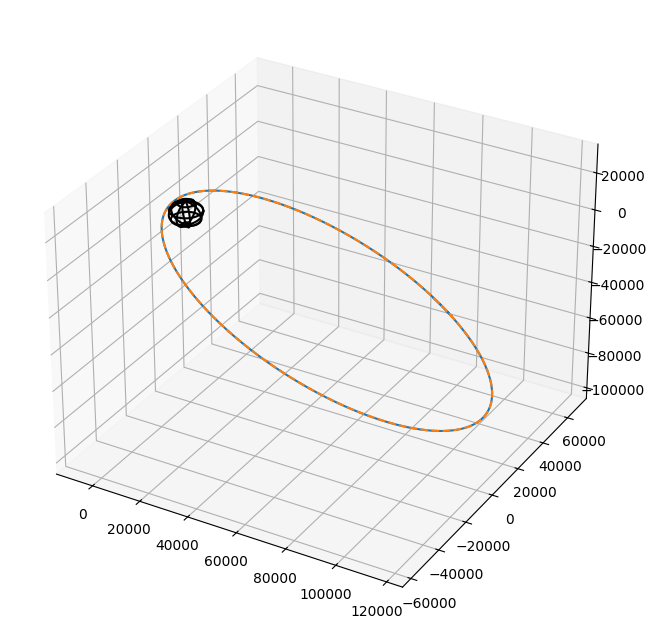

In [64]:
# plotting

fig = plt.figure(figsize=[10, 8])

ax  = fig.add_subplot(1, 1, 1, projection='3d')

x = np.transpose(r_get(fm8))[0]
y = np.transpose(r_get(fm8))[1]
z = np.transpose(r_get(fm8))[2]

ax.plot(x,y,z)
ax.plot(xk,yk,zk,ls='dashed')

for x, y, z in lons:
    ax.plot(x, y, z, '-k')
for x, y, z in lats:
    ax.plot(x, y, z, '-k')

# ax.view_init(135, -90)

centers, hw = makecubelimits(ax)
# plt.savefig('c2orb-11.png',dpi=300,bbox_inches='tight')
plt.show()

In [59]:
# run before plotting
def makecubelimits(axis, centers=None, hw=None):
    lims = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
    if centers == None:
        centers = [0.5*sum(pair) for pair in lims] 

    if hw == None:
        widths  = [pair[1] - pair[0] for pair in lims]
        hw      = 0.5*max(widths)
        ax.set_xlim(centers[0]-hw, centers[0]+hw)
        ax.set_ylim(centers[1]-hw, centers[1]+hw)
        ax.set_zlim(centers[2]-hw, centers[2]+hw)
#         print("hw was None so set to:", hw)
    else:
        try:
            hwx, hwy, hwz = hw
#             print("ok hw requested: ", hwx, hwy, hwz)

            ax.set_xlim(centers[0]-hwx, centers[0]+hwx)
            ax.set_ylim(centers[1]-hwy, centers[1]+hwy)
            ax.set_zlim(centers[2]-hwz, centers[2]+hwz)
        except:
#             print("nope hw requested: ", hw)
            ax.set_xlim(centers[0]-hw, centers[0]+hw)
            ax.set_ylim(centers[1]-hw, centers[1]+hw)
            ax.set_zlim(centers[2]-hw, centers[2]+hw)

    return centers, hw

r_e = 6371.

theta = np.linspace(0, 2*np.pi, 201)
cth, sth, zth = [f(theta) for f in (np.cos, np.sin, np.zeros_like)]
lon0 = r_e*np.vstack((cth, zth, sth))
lons = []
for phi in np.pi/180*np.arange(0, 180, 45):
    cph, sph = [f(phi) for f in (np.cos, np.sin)]
    lon = np.vstack((lon0[0]*cph - lon0[1]*sph,
                     lon0[1]*cph + lon0[0]*sph,
                     lon0[2]) )
    lons.append(lon)

lat0 = r_e*np.vstack((cth, sth, zth))
lats = []
for phi in np.pi/180*np.arange(-75, 90, 45):
    cph, sph = [f(phi) for f in (np.cos, np.sin)]
    lat = r_e*np.vstack((cth*cph, sth*cph, zth+sph))
    lats.append(lat)